<a href="https://colab.research.google.com/github/mjaafar97/Physics_publicartion_network_analysis/blob/main/Co_authorship_Social_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing the Co-authorship social Network

The purpose of this project is to analyze the physics co-authorship social network by comparing it to two variations of the same network: a randomly rewired social network (Where the connections between nodes are randomly selected) and an [Erdos Renyi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)  network.



In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt 
from collections import Counter 
import collections
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
import itertools

import community as com

## Reading data

In [2]:
url = 'https://raw.githubusercontent.com/mjaafar97/Physics_publicartion_network_analysis/main/arxiv.txt'
coauthorship_data = pd.read_csv(url, header = None, usecols= [0,1,2,3,4])

In [3]:
coauthorship_data.head()

,0,1,2,3,4
0,1992,B368,Nucl.Phys.,Horne & Horowitz,Exact Black String Solutions in Three Dimens...
1,1992,B278,Phys. Lett.,Mikovic,Hamiltonian construction of W-gravity actions
2,1991,A6,Mod. Phys. Lett.,Huitu & Nemeschansky,Supersymmetric Gelfand-Dickey Algebra
3,1992,B373,Nucl.Phys.,Witten,Ground Ring Of Two Dimensional String Theory
4,1991,A6,Mod.Phys.Lett.,Intriligator,Fusion Residues


## Data preprocessing 
**The data preprocessing steps include:**

    1- Splitting the authors column using the & charachter 
    2- Forming a pairs dataset that represents the edges betwen auhtors
    3- Removing single author paper by removing pairs with "Nan" or "None" present
    4- Converting names into lower case to unify the author names
    5- Removing special charachters from names to unify the names
    6- Removing self edges (Edges from a node to itself)
    7- Removing the direction of the edges by sorting the pairs by vale 
    8- agreggating multiple edges (collaborations) to calculate the weight of the edge.
    9- Removing names with empty strings


In [4]:
processed_data = coauthorship_data[3].str.split('&', expand=True)
processed_data = processed_data.fillna(value=np.nan)
processed_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,Horne,Horowitz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mikovic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Huitu,Nemeschansky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Witten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Intriligator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pairs=pd.DataFrame(processed_data.apply(lambda x : list(zip(x.dropna()[:-1],x.dropna()[1:])),
                               axis=1).explode().tolist())
pairs = pairs.fillna(value=np.nan)
pairs = pairs.dropna(axis=0)
pairs = pairs.apply(lambda x : x.str.lower())
pairs = pairs.apply(lambda x : x.str.replace('[^a-zA-Z]', ''))
pairs = pairs.dropna(axis=0)
pairs = pairs[pairs[0] != pairs[1]]
pairs = pairs[pairs[0]!='']
pairs = pairs[pairs[1]!='']
pairs.columns= ["Author_1" , "Author_2"]

In [6]:
pairs.head()

,Author_1,Author_2
0,horne,horowitz
2,huitu,nemeschansky
5,ooguri,sasakura
6,leclair,smirnov
9,lerche,smit


## The Original Co-Authorship Dataframe

In [7]:
Sorted_pairs=pairs[pairs.iloc[-1,:].sort_values().index]
Sorted_pairs.head()

,Author_2,Author_1
0,horowitz,horne
2,nemeschansky,huitu
5,sasakura,ooguri
6,smirnov,leclair
9,smit,lerche


In [8]:
weighted_graph =pairs.groupby(Sorted_pairs.columns.tolist(),as_index=False).size()
weighted_graph.head()

,Author_2,Author_1,size
0,a,ambjorn,1
1,a,basagoiti,1
2,a,n,1
3,a,p,1
4,aa,bertrand,1


In [9]:
weighted_graph.shape

(9762, 3)

## The Network properties 

In [10]:
print ('The total number of authors = ',len(set(pairs['Author_1']).union(set(pairs['Author_2']))))


The total number of authors =  5402


In [11]:
print ('The unique values in the first author = ',len(np.unique(pairs['Author_1'])))
print ('The unique values in the second author = ',len(np.unique(pairs['Author_2'])))

The unique values in the first author =  4148
The unique values in the second author =  4066


## Building The Random Rewired Network

To generate the random rewired network the following was done:


    1- Each edge was considered on its own without the weight.
    2- The destination of the edge "Author_2" was changed by selecting a random author.
    3- This process doesn't require discounting the edges that are already re-wired because each edge is considered only once. 

In [12]:
Authors = set(pairs['Author_1']).union(set(pairs['Author_2']))

In [13]:
print ("The number of authors is " , len(Authors))

The number of authors is  5402


In [14]:
Authors = list (Authors)

In [15]:
rewired_network = pairs.copy()
rewired_network['updated_author'] = random.choices(Authors,k=rewired_network.shape[0])
rewired_network = rewired_network.drop(columns= 'Author_2', axis=1)
rewired_network.columns=['Author_1', 'Author_2']
rewired_network.head()

,Author_1,Author_2
0,horne,kubotani
2,huitu,menotti
5,ooguri,marchioro
6,leclair,balaska
9,lerche,follana


In [16]:
Sorted_rewired_network=rewired_network[rewired_network.iloc[-1,:].sort_values().index]
rewired_weighted_graph =pairs.groupby(Sorted_rewired_network.columns.tolist(),as_index=False).size()
rewired_weighted_graph.head()

,Author_2,Author_1,size
0,a,ambjorn,1
1,a,basagoiti,1
2,a,n,1
3,a,p,1
4,aa,bertrand,1


In [17]:
rewired_network = nx.from_pandas_edgelist(rewired_weighted_graph, 'Author_1', 'Author_2', ["size"])

## Building The Erdos Renyi Network

In [18]:
#ER_network = nx.from_pandas_edgelist(ER_weighted_graph, 'Author_1', 'Author_2', ["size"])
ER_network= nx.erdos_renyi_graph(5402, 0.00065)

In [19]:
ER_network.number_of_edges()

9461

In [20]:
ER_network.order()

5402

## Building the orginal network

In [21]:
original_network = nx.from_pandas_edgelist(weighted_graph, 'Author_1', 'Author_2', ["size"])
print("The network size is " ,original_network.size())
print (" The network order is ",original_network.order() )

The network size is  9563
 The network order is  5402


## Plotting the three networks

In [22]:
def plot_network(network , color, title ):
  pos = nx.spring_layout(network)
  nx.draw_networkx_nodes(network, pos , node_size = 15,node_color=color)
  nx.draw_networkx_edges(network, pos,  edge_color=color)
  plt.title(title)
  plt.show()

### Original Network

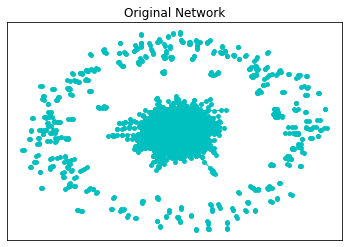

In [23]:
plot_network(original_network , 'c', 'Original Network')

### Erdos Renyi Network

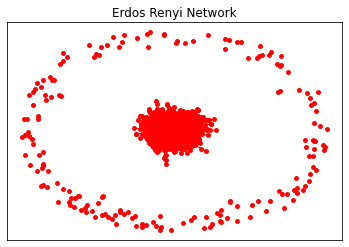

In [24]:
plot_network(ER_network , 'r', 'Erdos Renyi Network')

### Random Network

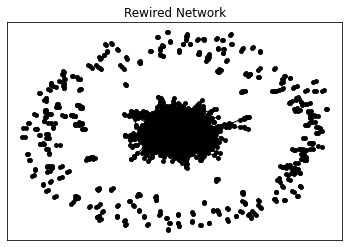

In [25]:
plot_network(rewired_network ,  'k', 'Rewired Network')

## Degree distribution plot

In [26]:
def plot_degree_distribution(network , style, title):
  degrees = network.degree()
  degree_dict = dict(degrees)
  degree_values = sorted(set(degree_dict.values()))
  degrees_list = list(degree_dict.values())
  degree_hist = [degrees_list.count(x) for x in degree_values]
  plt.figure() 
  plt.grid(True)
  plt.plot(degree_values, degree_hist, style)
  plt.xlabel('Degree')
  plt.ylabel('Number of nodes')
  plt.title(title)



### Original Network 

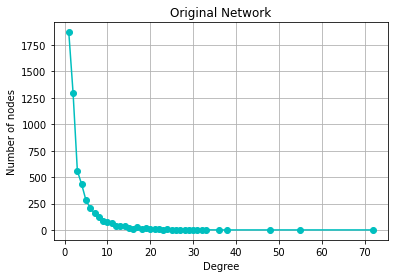

In [27]:
plot_degree_distribution(original_network, 'co-',"Original Network")

### Random Network

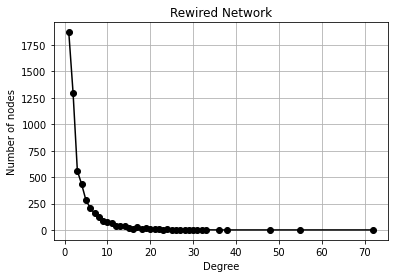

In [28]:
plot_degree_distribution(rewired_network, 'ko-', 'Rewired Network')

### Erdos Renyi Network


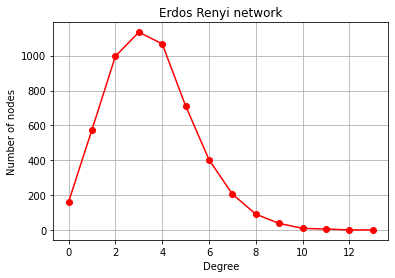

In [29]:
plot_degree_distribution(ER_network , 'ro-', "Erdos Renyi network")

## Degree distributions log log plot



In [30]:
def plot_log_degree_distribution(network , style , title):
  degrees = network.degree()
  degree_dict = dict(degrees)
  degree_values = sorted(set(degree_dict.values()))
  degrees_list = list(degree_dict.values())
  degree_hist = [degrees_list.count(x) for x in degree_values]
  plt.figure() 
  plt.grid(True)
  plt.loglog(degree_values,degree_hist,style )
  plt.xlabel('Degree')
  plt.ylabel('Number of nodes')
  plt.title(title)



### Original Network

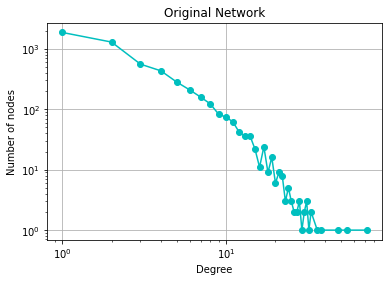

In [31]:
plot_log_degree_distribution(original_network , 'co-', 'Original Network')

### Random Network

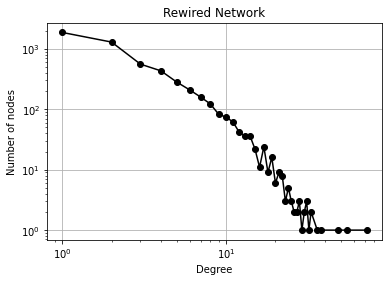

In [32]:
plot_log_degree_distribution(rewired_network, 'ko-', "Rewired Network")

### Erdos Renyi Network

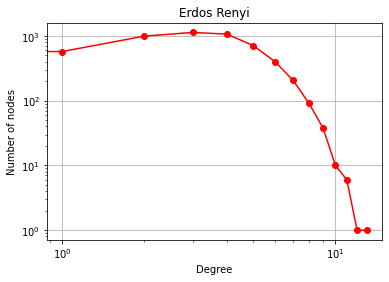

In [33]:
plot_log_degree_distribution(ER_network , 'ro-', "Erdos Renyi")

## Degree distribution of all three networks 

In [34]:
 def get_degree_distribution(network):
  degrees = network.degree()
  degree_dict = dict(degrees)
  degree_values = sorted(set(degree_dict.values()))
  degrees_list = list(degree_dict.values())
  degree_hist = [degrees_list.count(x) for x in degree_values]
  return degree_values, degree_hist

In [35]:
ER_vals, ER_hist = get_degree_distribution(ER_network)
rewired_vals, rewired_hist = get_degree_distribution(rewired_network)
original_vals, original_hist = get_degree_distribution(original_network)

<Figure size 36000x18000 with 0 Axes>

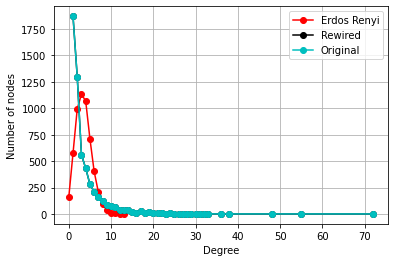

<Figure size 36000x18000 with 0 Axes>

In [36]:
plt.figure() 
plt.grid(True)
plt.plot(ER_vals, ER_hist, 'ro-', label = "Erdos Renyi")
plt.plot(rewired_vals, rewired_hist, 'ko-', label = "Rewired ")
plt.plot(original_vals, original_hist, 'co-' , label = "Original")
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.legend()
plt.figure(figsize=(500,250))

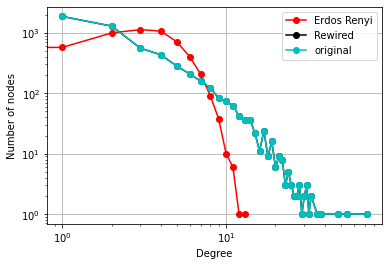

In [37]:
plt.figure() 
plt.grid(True)
plt.loglog(ER_vals, ER_hist, 'ro-', label = "Erdos Renyi")
plt.loglog(rewired_vals, rewired_hist, 'ko-', label = "Rewired")
plt.loglog(original_vals, original_hist, 'co-', label = "original")
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.legend()

##  Clustering cooficient Vs degree plots

In [ ]:
def plot_clustering_vs_degree(network , dots_style, title):
  clust_coefficients = nx.clustering(network)
  degrees = dict(network.degree())
  degrees_df = pd.DataFrame(list(degrees.items()),columns = 
                               ['Author','Degree']) 
  clustering_df = pd.DataFrame(list(clust_coefficients.items()),columns =
                              ['Author','Clustering']) 
  Clustering_degree = pd.merge(left=clustering_df, right=degrees_df,
                                how='left', left_on='Author', right_on='Author')
  Clustering_degree.plot(x='Degree', y='Clustering', style=dots_style)
  plt.title(title)
  return Clustering_degree



### Clusttering cooficient VS the segree of Erdos Renyi network

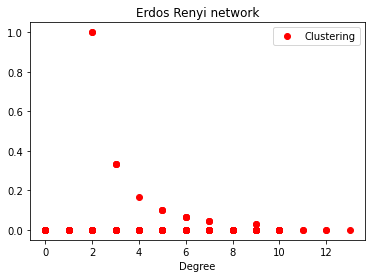

In [ ]:
ER_clustering_degree = plot_clustering_vs_degree(ER_network , 'ro', "Erdos Renyi network")

### Clustering Cofficient Vs Degree in Original Network

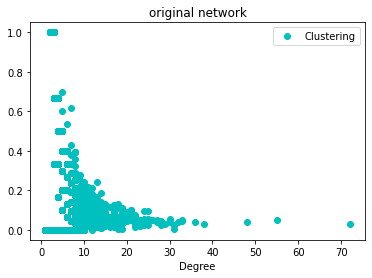

In [ ]:
Original_clustering_degree = plot_clustering_vs_degree(original_network , 'co', "original network")

### CLustering Cooficient Vs Degree in randomly rewired network

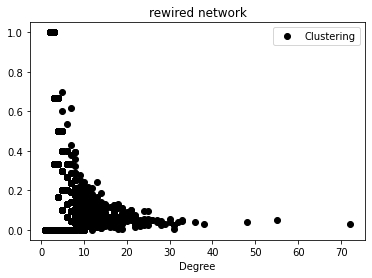

In [ ]:
rewired_clutering_degree = plot_clustering_vs_degree(rewired_network, 'ko', "rewired network")

## Clustering Cooficient analysis


In [39]:
def get_average_clustering_coof(network , network_name):
  clust_coefficients = nx.clustering(network)
  avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
  print ( " the average clustering cooficient for " , network_name, avg_clust)



In [40]:
get_average_clustering_coof(ER_network , "Erdos Renyi Network")

 the average clustering cooficient for  Erdos Renyi Network 0.0005120090736529093


In [41]:
get_average_clustering_coof(original_network , "Original network")

 the average clustering cooficient for  Original network 0.12254643582107418


In [42]:
get_average_clustering_coof(rewired_network, "Rewired network")

 the average clustering cooficient for  Rewired network 0.12254643582107418


## Shortest path analysis

In [43]:
def get_paths_dist(network ):
  paths = dict(nx.all_pairs_shortest_path_length(network))
  hist_1 = Counter(paths[0].values())
  for i in range (1, len(paths)):
    hist =  Counter(paths[i].values())
    hist_1 = hist_1+hist
  return dict(hist_1)


In [44]:
def get_paths_dist2(network ):
  paths = nx.all_pairs_shortest_path_length(network)
  hist_1 = Counter()
  for path in paths:
    hist =  Counter(path[1].values())
    hist_1 = hist_1+hist
  return dict(hist_1)


In [45]:
def plot_path_dist(path_hist, color , title ):
  values = [] #in same order as traversing keys
  keys = [] #also needed to preserve order
  for key in path_hist.keys():
    keys.append(key)
    values.append(path_hist[key])
  plt.figure() 
  plt.grid(True)
  plt.plot(keys,values , color = color)
  plt.xlabel('Path length' )
  plt.ylabel('Frequency')
  plt.title(title)

### The distribution of the shortest path in the Erdos Renyi Social Network

In [46]:
ER_path_dist= get_paths_dist(ER_network )

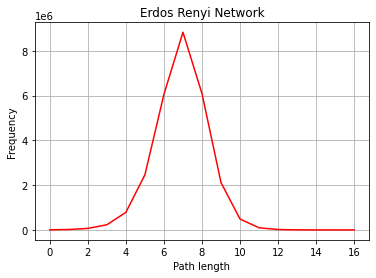

In [47]:
plot_path_dist(ER_path_dist, 'r' , 'Erdos Renyi Network')

### The distribution of the shortest path in the Original Social Network

In [48]:
original_hist = get_paths_dist2(original_network)

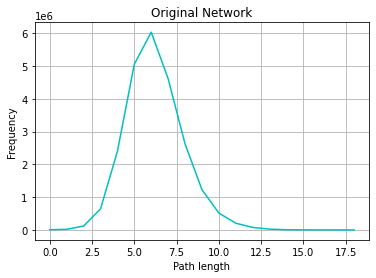

In [49]:
plot_path_dist(original_hist, 'c', "Original Network")

### The distribution of the shortest path in the randomly rewired Social Network

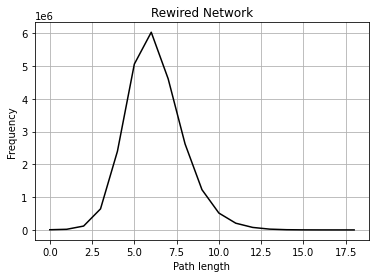

In [50]:
rewired_hist = get_paths_dist2(rewired_network)
plot_path_dist(rewired_hist, 'k' , 'Rewired Network')

## Connected components analysis

In [ ]:
def plot_connected_dist(network, color , title):
  connected_hist =  dict(Counter([len(c) for c in sorted(nx.connected_components(network), key=len, reverse=False)]))
  values = [] #in same order as traversing keys
  keys = [] #also needed to preserve order
  for key in connected_hist.keys():
    keys.append(key)
    values.append(connected_hist[key])
  print(keys)
  print(values)
  plt.figure() 
  plt.grid(True)
  plt.loglog(keys,values , color = color)
  plt.xlabel('Connected Component sizes' )
  plt.ylabel('Frequency')
  plt.title(title)



### The size of connected components in the Erdos Renyi Social Network

[1, 2, 5199]
[185, 9, 1]


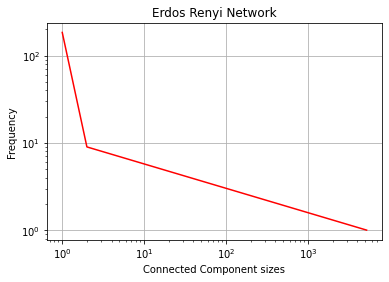

In [ ]:
plot_connected_dist(ER_network, 'r' , 'Erdos Renyi Network')

### The size of connected components in the  Original Social Network

[2, 3, 4, 5, 6, 7, 8, 11, 4853]
[138, 31, 22, 8, 3, 1, 2, 1, 1]


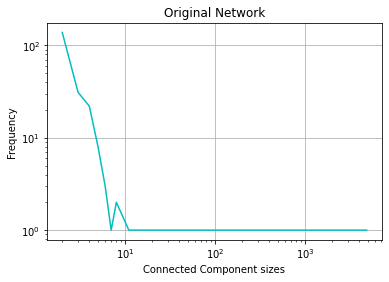

In [ ]:
plot_connected_dist(original_network, 'c' , "Original Network")

### The size of connected components in the randomly rewired social Network

[2, 3, 4, 5, 6, 7, 8, 11, 4853]
[138, 31, 22, 8, 3, 1, 2, 1, 1]


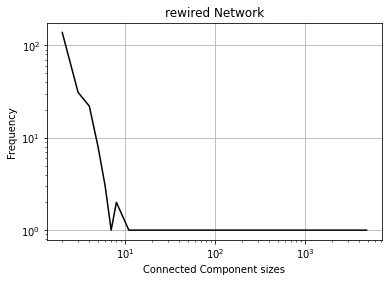

In [ ]:
plot_connected_dist(rewired_network, 'k' , "rewired Network")

## Betweenness Centrality Analysis 

In [ ]:
def get_betweenness_dist(network, param):
  betweenness_dict = nx.betweenness_centrality(ER_network, k=None, normalized =True)
  betweenness_values = list(betweenness_dict.values())
  ranges = np.arange(0, 1 , 0.001)
  betweenness_dist_dict = {}
  for i in range (param):
    betweenness_dist_dict[ranges[i]]=sum(map(lambda x : x>ranges[i] and x <= ranges[i+1], betweenness_values))
  return betweenness_dist_dict

In [ ]:
ER_betweenness_dist = get_betweenness_dist(ER_network,15)

In [ ]:
def plot_betweenness_dist(betweenness_hist, color , title):
  values = [] #in same order as traversing keys
  keys = [] #also needed to preserve order
  for key in betweenness_hist.keys():
    keys.append(key)
    values.append(betweenness_hist[key])
  print(len(keys))
  print(len(values))
  plt.figure() 
  plt.hist(keys,keys, weights = values , color = color)
  plt.xlabel('Betweenness values' )
  plt.ylabel('Frequency')
  plt.title(title)



### The Betweenness Cebtrality of the Erdos Renyi Social Network

15
15


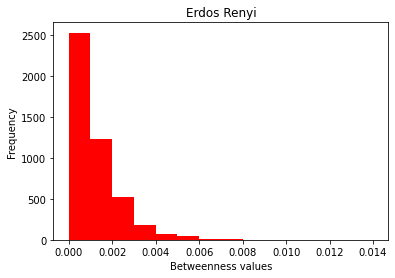

In [ ]:
plot_betweenness_dist(ER_betweenness_dist,'r', 'Erdos Renyi')

### The Betweenness Cebtrality of the Original  Social Network

In [ ]:
original_betweenness_dist = get_betweenness_dist(original_network,15)

15
15


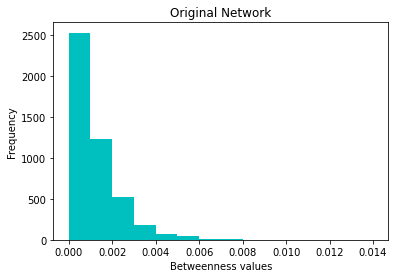

In [ ]:
plot_betweenness_dist(original_betweenness_dist,'c', 'Original Network')

### The Betweenness Cebtrality of the Rewired Social Network

In [ ]:
rewired_betweenness_dist = get_betweenness_dist(rewired_network,15)

15
15


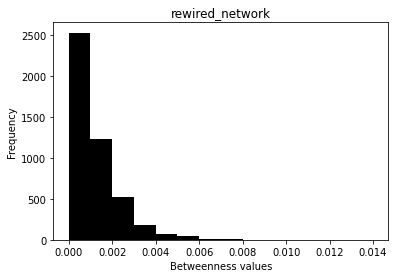

In [ ]:
plot_betweenness_dist(rewired_betweenness_dist , 'k', 'rewired_network')

# Community detetction in Networks

## Gervan Neumen Algorithm

In [51]:
rewired_network = nx.from_pandas_edgelist(rewired_weighted_graph, 'Author_1', 'Author_2', ["size"])
ER_network= nx.erdos_renyi_graph(5402, 0.00065)
original_network = nx.from_pandas_edgelist(weighted_graph, 'Author_1', 'Author_2', ["size"])


In [52]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    sorted_betweenness = sorted(centrality.items(), key=lambda s: s[1])
    return sorted_betweenness[0]


In [53]:
def gervan_neumen_results(network, itr):
  modularity_values=[]
  for i in range (itr):
   print ("iteration", i)
   curr_center = most_central_edge(network)
   network.remove_edge(*curr_center[0])
   part = com.best_partition(network)
   modularity_values.append( com.modularity(part,network))
  return part,modularity_values

In [54]:
ER_partition , ER_results= gervan_neumen_results(ER_network ,2 )

iteration 0
iteration 1


In [67]:
print("The average Modularity value for Erdos Renyi Social network" ,np.mean(ER_results))

The average Modularity value for Erdos Renyi Social network 0.5797629544720837


In [55]:
Original_partition, original_results= gervan_neumen_results(original_network,2 )

iteration 0
iteration 1


In [68]:
print("The average Modularity value for the original Social network" ,np.mean(original_results))

The average Modularity value for the original Social network 0.7237304710580956


In [70]:
rewired_partition , rewired_results= gervan_neumen_results(rewired_network, 2)

iteration 0
iteration 1


In [71]:
print("The average Modularity value for the random Social network" ,np.mean(rewired_results))

The average Modularity value for the random Social network 0.7223539970665496
